In [ ]:
!pip install node2vec

import networkx as nx
import numpy as np
from networkx.algorithms import approximation
from networkx.algorithms import reciprocity
import matplotlib.pyplot as plt
from collections import Counter
import random
from itertools import combinations, groupby
from node2vec import Node2Vec
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

import statistics

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [ ]:
!tar -xvf "/content/facebook.tar" -C "/content/facebook/"

facebook/
facebook/3980.egofeat
facebook/0.featnames
facebook/698.egofeat
facebook/3437.feat
facebook/3980.featnames
facebook/0.edges
facebook/3437.circles
facebook/686.circles
facebook/348.egofeat
facebook/107.feat
facebook/348.feat
facebook/1912.circles
facebook/3437.egofeat
facebook/698.feat
facebook/348.edges
facebook/1912.feat
facebook/414.circles
facebook/1684.egofeat
facebook/1684.featnames
facebook/1684.feat
facebook/107.egofeat
facebook/0.circles
facebook/414.edges
facebook/698.featnames
facebook/698.edges
facebook/1912.featnames
facebook/107.edges
facebook/107.circles
facebook/0.egofeat
facebook/414.featnames
facebook/3980.feat
facebook/3437.featnames
facebook/1912.egofeat
facebook/414.egofeat
facebook/698.circles
facebook/348.featnames
facebook/348.circles
facebook/0.feat
facebook/1684.circles
facebook/3437.edges
facebook/3980.edges
facebook/686.featnames
facebook/1912.edges
facebook/3980.circles
facebook/686.feat
facebook/1684.edges
facebook/414.feat
facebook/686.egofeat
fa

In [ ]:
def node2vec_from_graph(G, D):
    node2vec = Node2Vec(G, dimensions=D)
    model = node2vec.fit()
    embeddings = model.wv.vectors
    return embeddings

In [ ]:
def get_circle_labels(G,circles):
    circle_labels = []
    for node in G.nodes():
        is_added = False
        for i,li in enumerate(list(circles.values())):
            if node in li and not is_added:
                circle_labels.append(i)
                is_added = True
        if not is_added:
            circle_labels.append(-1)
    return circle_labels

In [ ]:
def get_community_labels(G, circles):
    community_labels = []
    for node in G.nodes():
        is_added = False
        for i,li in enumerate(lab):
            if node in li and not is_added:
                community_labels.append(i)
                is_added = True
        if not is_added:
            community_labels.append(-1)
    return community_labels

In [ ]:
def colorize_nodes(labels, G):
    final = [(0,0,0) for i in range(len(G.nodes()))]
    colors = [(np.random.random(1)[0],np.random.random(1)[0],np.random.random(1)[0]) for i in range(len(labels))]

    for j,n in enumerate(G.nodes()):
        for i,label in enumerate(labels):
            if n in label:
                final[j]=colors[i]
    return final

In [ ]:
def explore_and_summarize_network(edgelist, vertices, subgraph, directed=False, circles=None):
    """
    Concisely summarizes any induced subgraph of the input network
    """
    G = nx.Graph()
    if subgraph is not None:
        induced_edges = [ edge for edge in edgelist if ((edge[0] in subgraph) and (edge[1] in subgraph))]
        G.add_nodes_from(subgraph)
        G.add_edges_from(induced_edges, nodetype=int)
    else :
        G.add_nodes_from(vertices)
        G.add_edges_from(edgelist, nodetype=int)
    G = list(G.subgraph(c) for c in nx.connected_components(G))[0]
    sum_list, labels, modularity, isolates = local_summaries_v2(G)
    # (a)
    nx.draw(G,pos=nx.fruchterman_reingold_layout(G),node_color=colorize_nodes(labels, G),
        node_size=20,
        edge_color="gray",
        width=0.5, cmap=plt.cm.Blues)
    plt.show()
    if circles:
        nx.draw(G,pos=nx.fruchterman_reingold_layout(G),node_color=colorize_nodes([set(item) for item in circles.values()],G),
        node_size=20,
        edge_color="gray",
        width=0.5, cmap=plt.cm.Blues)


    # (b)
    if directed:
        in_degree_sequence = [item[-2] for item in local_summaries_v2(G)[0]]
        in_degree_counts = Counter(degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(in_degree_counts.keys(), in_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('In Degrees')
        ax.set_title(r'Histogram of in_degrees')
        fig.tight_layout()
        plt.show()

        out_degree_sequence = [item[-1] for item in local_summaries_v2(G)[0]]
        out_degree_counts = Counter(out_degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(out_degree_counts.keys(), out_degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of out_degrees')
        fig.tight_layout()
        plt.show()

        reciprocity_sequence = [item[-1] for item in local_summaries_v2(G)[0]]
        reciprocity_counts = Counter(reciprocity_sequence)
        fig, ax = plt.subplots()
        ax.bar(reciprocity_counts.keys(), reciprocity_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('out Degrees')
        ax.set_title(r'Histogram of Reciprocity')
        fig.tight_layout()
        plt.show()
    else:
        degree_sequence = [item[-1] for item in local_summaries_v2(G)[0]]
        degree_counts = Counter(degree_sequence)
        fig, ax = plt.subplots()
        ax.bar(degree_counts.keys(), degree_counts.values())
        ax.set_xlabel('Nodes')
        ax.set_ylabel('Degrees')
        ax.set_title(r'Histogram of degrees')
        fig.tight_layout()
        plt.show()
    # (c)
    betweenness_centrality = [item[0] for item in local_summaries_v2(G)[0]]
    fig1, ax1 = plt.subplots()
    ax1.hist(betweenness_centrality)
    ax1.set_xlabel('Nodes')
    ax1.set_ylabel('Betweenness Centrality')
    ax1.set_title(r'Histogram of Betweenness Centrality')
    fig1.tight_layout()
    plt.show()
    # (d)
    eigenvector_centrality = [item[1] for item in local_summaries_v2(G)[0]]
    fig2, ax2 = plt.subplots()
    ax2.hist(eigenvector_centrality)
    ax2.set_xlabel('Nodes')
    ax2.set_ylabel('Eigenvector Centrality')
    ax2.set_title(r'Histogram of Eigenvector Centrality')
    fig2.tight_layout()
    plt.show()
    # Print Global Summaries
    global_summaries(G)
    print("Modularity : ", modularity)
    return labels

In [ ]:
def local_summaries_v2(G, directed=False):

    betweenness_centrality = nx.centrality.betweenness_centrality(G)
    max_betweenness_centrality_node = max(betweenness_centrality, key=betweenness_centrality.get)
    eigenvector_centrality = nx.centrality.eigenvector_centrality(G)
    max_eigenvector_centrality = max(eigenvector_centrality, key=eigenvector_centrality.get)
    closeness_centrality = nx.centrality.closeness_centrality(G)
    max_closeness_centrality = max(closeness_centrality, key=closeness_centrality.get)

    if directed:
        in_degrees = [G.in_degree(n) for n in G.nodes]
        in_degree_dict= {n:G.degree(n) for n in G.nodes}
        max_in_degree = max(max_in_degree, key=max_in_degree.get)
        out_degrees = [G.in_degree(n) for n in G.nodes]
        out_degree_dict= {n:G.degree(n) for n in G.nodes}
        max_out_degree = max(out_degree_dict, key=out_degree_dict.get)
        reciprocity = nx.algorithms.reciprocity(G)
        mean_reciprocity = [value for key,value in nx.algorithms.reciprocity(G)].mean()
        return zip(betweenness_centrality.values(),
                   eigenvector_centrality.values(),
                   closeness_centrality.values(),
                   in_degrees,
                   out_degrees,
                   reciprocity,
                   nx.clustering(G)), max_betweenness_centrality_node, max_eigenvector_centrality, max_closeness_centrality, max_in_degree, max_out_degree, mean_reciprocity, nx.algorithms.isolate.number_of_isolates(G)
    else:
        degrees =[G.degree(n) for n in G.nodes]
        partitions = list(nx.algorithms.community.centrality.girvan_newman(G))
        mod_scores = [nx.community.quality.modularity(G, partition) for partition in partitions]
        maximum_modularity_score = max(mod_scores)
        best_partition = partitions[mod_scores.index(maximum_modularity_score)]
        return zip(betweenness_centrality.values(),
                   eigenvector_centrality.values(),
                   closeness_centrality.values(),
                   degrees,
                   nx.clustering(G)), best_partition,  maximum_modularity_score ,nx.algorithms.isolate.number_of_isolates(G)

In [ ]:
def global_summaries(G):
    try:
        diameter = nx.algorithms.distance_measures.diameter(G)
    except:
        diameter = "Found infinite path length because the graph is not connected !"
    clustering_coefficient = nx.algorithms.approximation.clustering_coefficient.average_clustering(G)
    number_of_nodes = G.number_of_edges()
    number_of_edges = G.number_of_nodes()
    number_of_connected_components = nx.number_connected_components(G)
    largest_connected_component = max([ len(i) for i in list(nx.connected_components(G))])
    print("##### Global Summaries #####")
    print("Diameter : ",diameter)
    print("Number of Nodes : ",number_of_nodes)
    print("Number of Edges : ",number_of_edges)
    print("Number of Connected Components : ",number_of_connected_components)
    print("Size of the Largest Connected Compopnent : ",largest_connected_component)

In [ ]:
def read_circles(file_path):
    with open(file_path) as f :
        content = f.readlines()
        content = [line.replace("\n","") for line in content]
        content = [line.split("\t") for line in content]
    return {circle[0]:list(map(int,circle[1:])) for circle in content} # Convert nodes to int and add to dict.

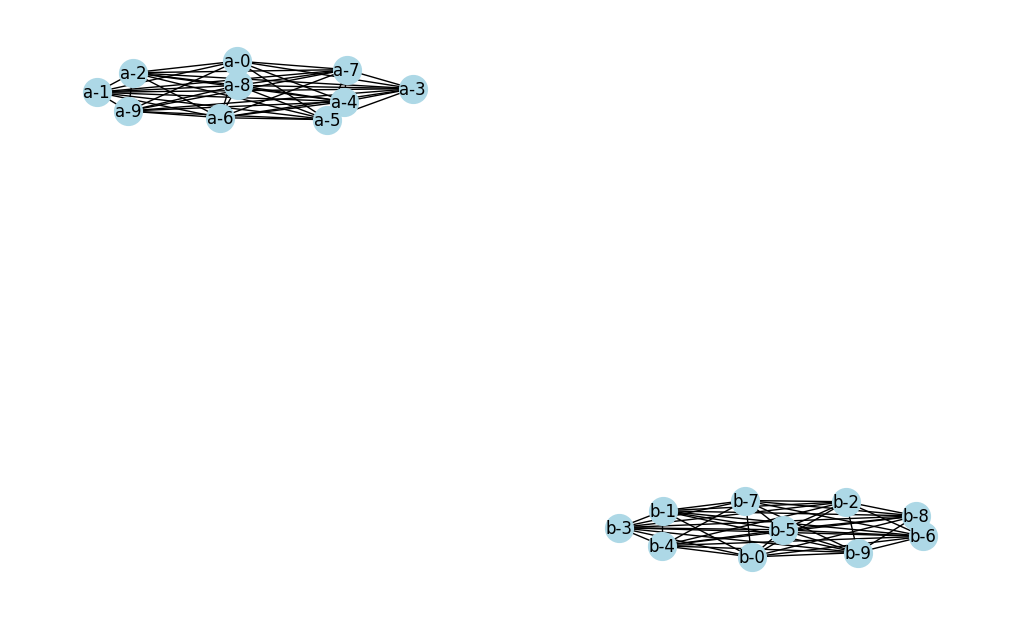

In [ ]:
G_random1 = nx.complete_graph(10)
G_random2 = nx.complete_graph(10)

G_combined = nx.union(G_random1, G_random2, rename=('a-', 'b-'))


plt.figure(figsize=(10,6))

nx.draw(G_combined, node_color='lightblue',
        with_labels=True,
        node_size=400)

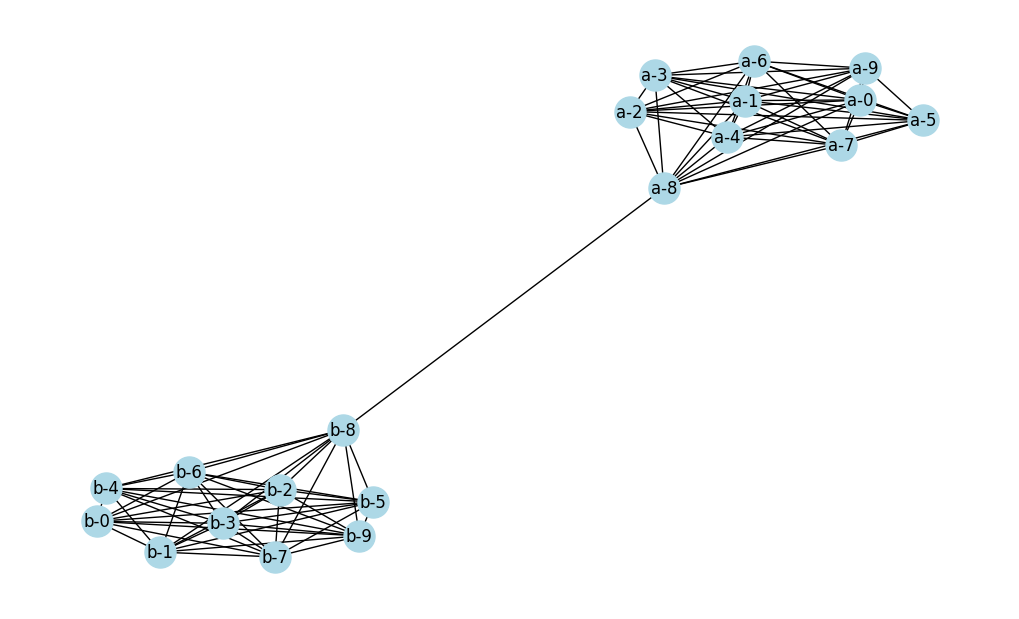

In [ ]:
G_combined.add_edge('b-8', 'a-8')

plt.figure(figsize=(10,6))

nx.draw(G_combined, node_color='lightblue',
        with_labels=True,
        node_size=500)

/usr/local/lib/python3.9/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


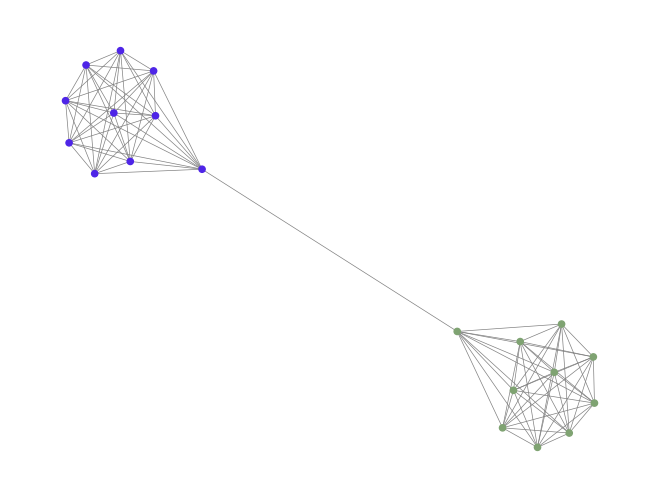

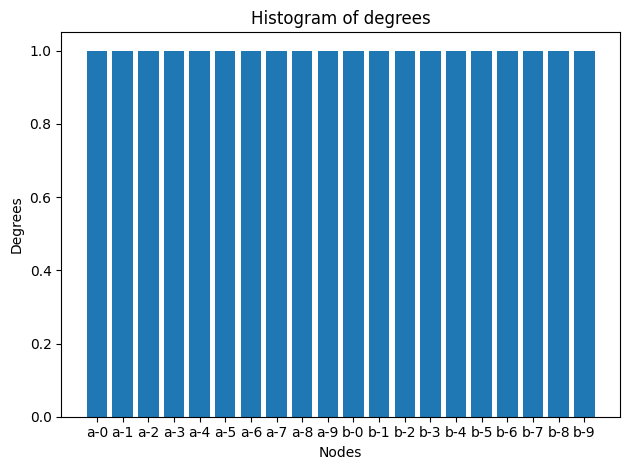

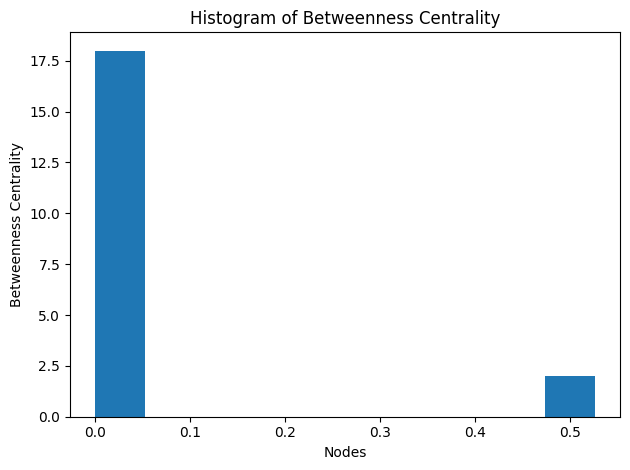

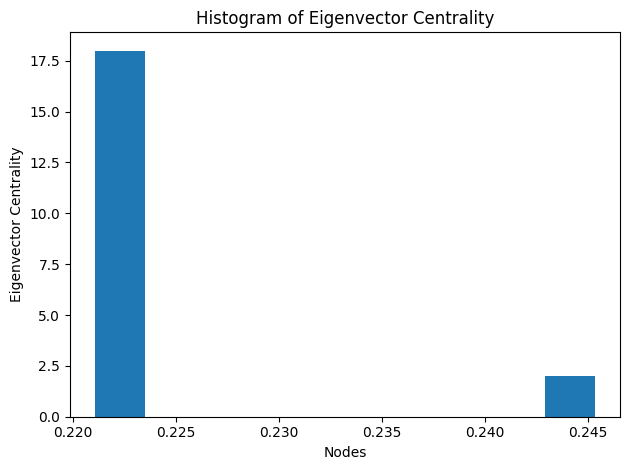

##### Global Summaries #####
Diameter :  3
Number of Nodes :  91
Number of Edges :  20
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  20
Modularity :  0.48901098901098905


In [ ]:
lab_small = explore_and_summarize_network(edgelist = G_combined.edges(), vertices=G_combined.nodes(), subgraph=None)

In [ ]:
G = nx.read_edgelist('/content/facebook/facebook/0.edges', nodetype=int)

In [ ]:
circles = read_circles("/content/facebook/facebook/0.circles")

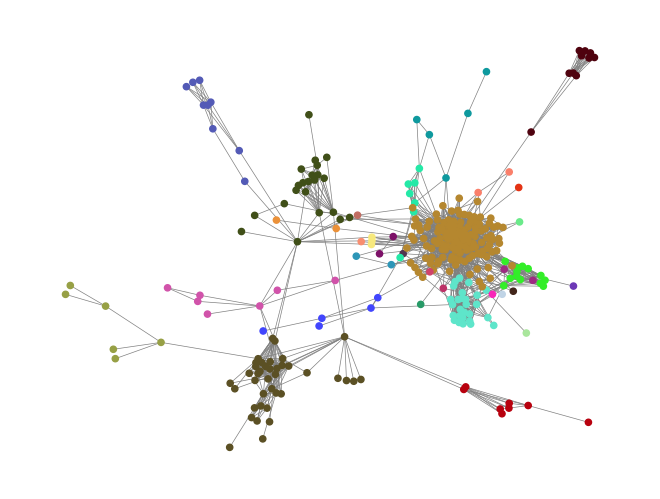

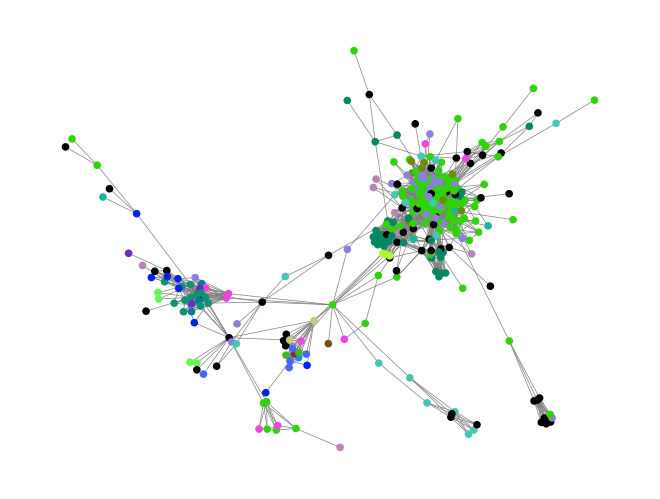

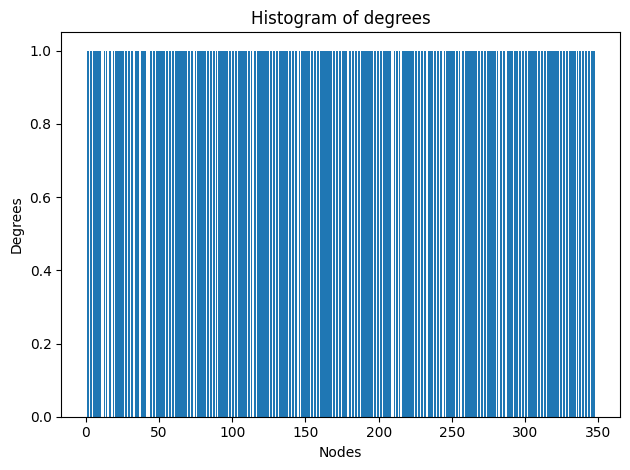

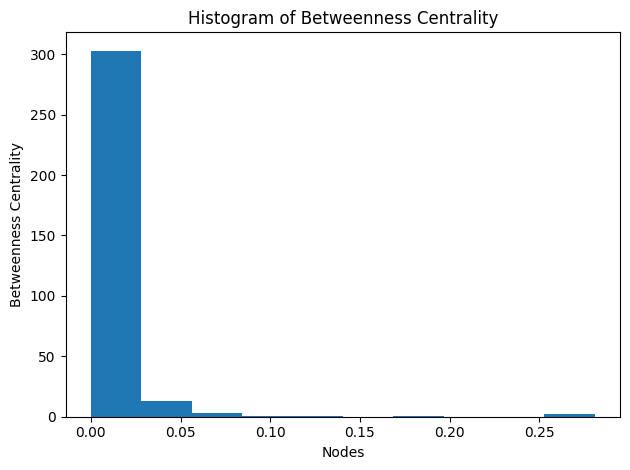

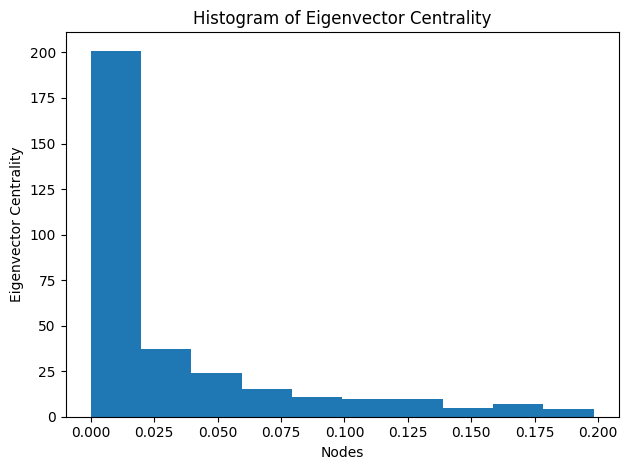

##### Global Summaries #####
Diameter :  11
Number of Nodes :  2514
Number of Edges :  324
Number of Connected Components :  1
Size of the Largest Connected Compopnent :  324
Modularity :  0.4139775886697185


In [ ]:
lab = explore_and_summarize_network(edgelist = G.edges(), vertices=G.nodes(), subgraph=None, circles=circles)

In [ ]:
maximums = [len(i) for i in lab]

In [ ]:
li = []
for i,partition in enumerate(lab):
    te = [0 for i in circles]
    for node in partition:
        for i,k in enumerate(circles.items()):
            print(k[1])
            if node in k[1]:
                te[i] += 1
    li.append(te)

Streaming output truncated to the last 5000 lines.
[251, 94, 330, 5, 34, 299, 254, 24, 180, 194, 281, 101, 266, 135, 197, 173, 36, 9, 85, 57, 37, 258, 309, 80, 139, 202, 187, 249, 58, 127, 48, 92]
[90, 52, 172, 126, 294, 179, 145, 105, 210]
[177]
[93, 33, 333, 17, 137, 44, 343, 326, 214, 115, 312, 41, 20]
[244, 282, 262, 293, 220, 174]
[12]
[267]
[28, 149, 162]
[71, 215, 54, 61, 298, 229, 81, 253, 193, 97, 264, 29, 132, 110, 163, 259, 183, 334, 245, 222]
[173]
[155, 99, 327, 140, 116, 147, 144, 150, 270]
[51, 83, 237]
[125, 344, 295, 257, 55, 122, 223, 59, 268, 280, 84, 156, 258, 236, 250, 239, 69]
[23]
[337, 289, 93, 17, 111, 52, 137, 343, 192, 35, 326, 310, 214, 32, 115, 321, 209, 312, 41, 20]
[225, 46]
[282]
[336, 204, 74, 206, 292, 146, 154, 164, 279, 73]
[42, 14, 216, 2]
[324, 265, 54, 161, 298, 76, 165, 199, 203, 13, 66, 113, 97, 252, 313, 238, 158, 240, 331, 332, 134, 218, 118, 235, 311, 151, 308, 212, 70, 211]
[278]
[138, 131, 68, 143, 86]
[175, 227]
[108, 208, 251, 125, 325, 1

In [ ]:
label_list = list(circles.keys())
top_5 = li[0] , li[4], li[1] , li[2] , li[3]
data = np.array(top_5)

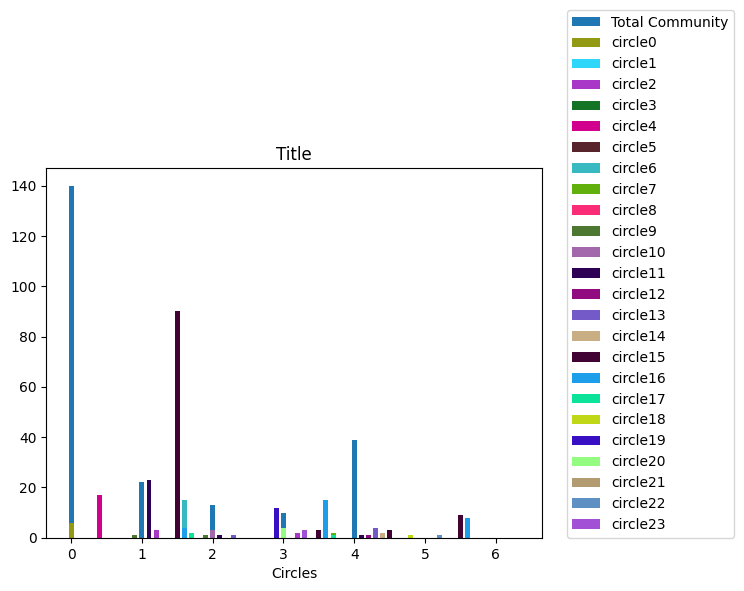

In [ ]:
ax = plt.subplot(111)
plt.rcParams["figure.figsize"] = (30,5)

x = [0,4,1,2,3]
y = [140, 39, 22, 13, 10]
ax.bar(x,y,width=0.07,label="Total Community")
x = np.arange(len(data))

for i in range(len(top_5[0])):
    ax.bar(x+(i*.1), data[:,i], width=0.07, color=(np.random.random(1)[0],np.random.random(1)[0],np.random.random(1)[0]), align='center',label=label_list[i])

ax.set_xlabel('Circles')
ax.set_title('Title')
ax.legend(loc=(1.05,0))
plt.show()

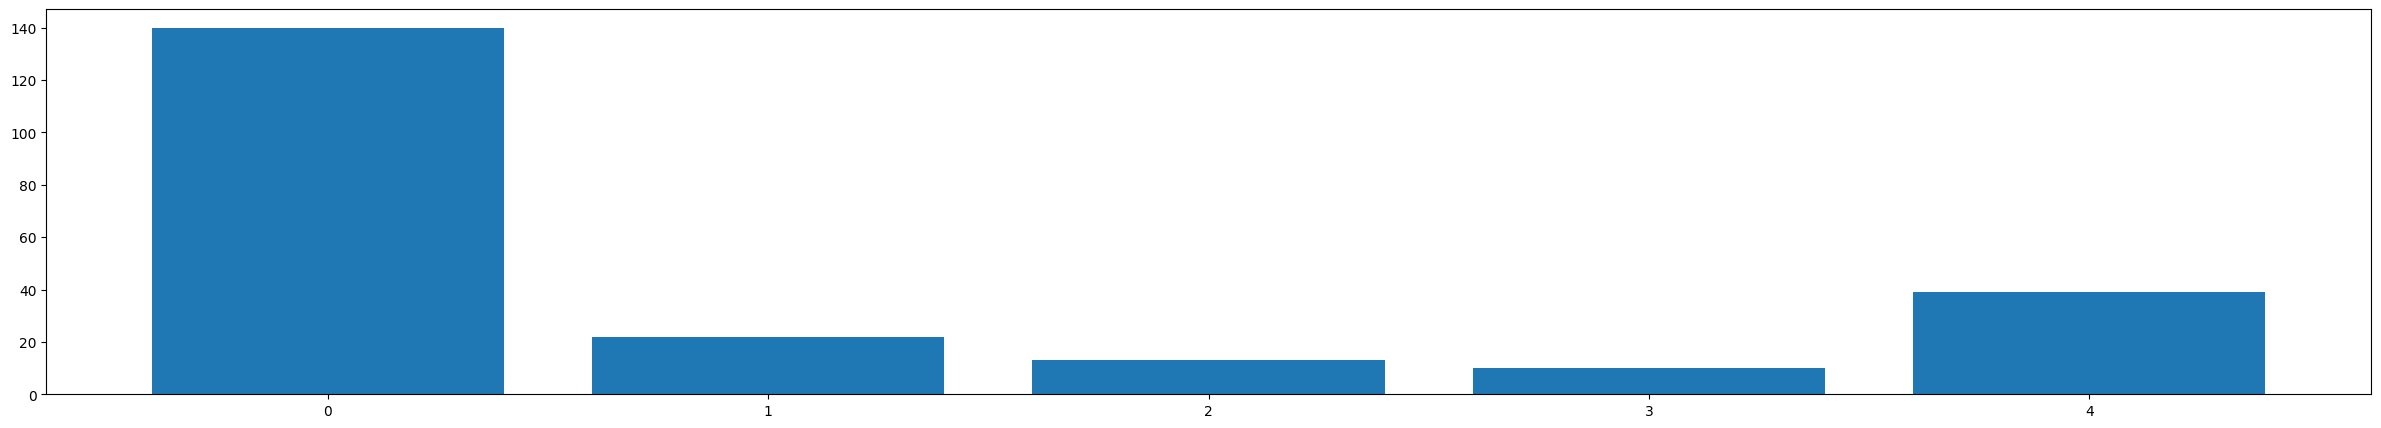

In [ ]:
x = [0,4,1,2,3]
y = [140, 39, 22, 13, 10]
plt.bar(x,y)


plt.show()

In [ ]:
G = nx.read_edgelist('/content/facebook/facebook/0.edges', nodetype=int)
circles = read_circles("/content/facebook/facebook/0.circles")
adjusted_rand_score(get_community_labels(G, circles), get_circle_labels(G, circles))

0.2440832661519791

In [ ]:
G = nx.read_edgelist('/content/facebook/facebook/107.edges', nodetype=int)
circles = read_circles("/content/facebook/facebook/107.circles")
adjusted_rand_score(get_community_labels(G, circles), get_circle_labels(G, circles))

0.0010857311623432766

###Node2Vec

In [ ]:
embeddings = node2vec_from_graph(G_combined,10)
embeddings[0:3] # sample 3 example

Computing transition probabilities:   0%|          | 0/20 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 81.90it/s]


array([[-0.7258947 ,  0.48262483, -0.27120426, -0.5070143 ,  0.48869282,
         0.12602511,  0.5617494 ,  0.43073872, -0.30562127,  0.59344786],
       [ 0.22418143, -0.576562  ,  0.1162251 ,  0.00092647,  0.12977819,
         0.41806275,  0.90546393,  0.35437074, -0.53917056,  0.45857924],
       [-0.7613529 ,  0.595573  , -0.35793874, -0.6051341 ,  0.674394  ,
         0.18822816,  0.484095  ,  0.45504558, -0.34917903,  0.6630435 ]],
      dtype=float32)

In [ ]:
G = nx.read_edgelist('/content/facebook/facebook/0.edges', nodetype=int)
circles = read_circles("/content/facebook/facebook/0.circles")
embeddings = node2vec_from_graph(G,30)

Computing transition probabilities:   0%|          | 0/333 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
kmeans.get_params()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 'warn',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}

In [ ]:
kmeans.cluster_centers_

array([[ 0.27847517,  0.07064447,  0.41597304,  0.00482032,  0.20362215,
         0.3729921 ,  0.24991219,  0.07300104, -0.16525353,  0.1629192 ,
         0.68129927, -0.08357085, -0.1577011 , -0.38655207,  0.66784316,
         0.02679133,  0.04581109,  0.37175393, -0.11587401,  0.10781628,
        -0.13153604, -0.23440969, -0.15046868,  0.6447439 ,  0.11159542,
         0.0027118 ,  0.22682965,  0.01702846, -0.03458121, -0.6894938 ],
       [ 0.7450106 , -0.6986414 , -0.27335313, -0.23362193,  0.5369753 ,
         0.251952  ,  0.06278543, -0.08183856, -0.5008554 ,  0.26279068,
         0.83564186,  0.11464833,  0.4684758 ,  0.10529836, -0.07222262,
         0.28146902,  0.74239147,  0.05404571, -0.802068  , -0.18054315,
        -0.2850163 , -1.0308827 ,  0.53384274,  0.2627644 ,  0.17400733,
        -0.8521941 ,  0.43853438, -0.08768513,  0.31782955, -1.2571101 ]],
      dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, get_circle_labels(G, circles), test_size=0.33, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
ypred = rf.predict(X_test)
score = f1_score(y_test,ypred,average = "micro")
print("F1 Score : ",score)

F1 Score :  0.3090909090909091


####Node107

In [ ]:
G = nx.read_edgelist('/content/facebook/facebook/107.edges', nodetype=int)
circles = read_circles("/content/facebook/facebook/107.circles")
embeddings = node2vec_from_graph(G,30)

Computing transition probabilities:   0%|          | 0/1034 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, get_circle_labels(G, circles), test_size=0.33, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
ypred = rf.predict(X_test)
score = f1_score(y_test,ypred,average = "micro")
print("F1 Score : ",score)

F1 Score :  0.49415204678362573
